In [27]:
import librosa
from scipy.fft import fft, ifft, fftfreq, rfft
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re
from sklearn import linear_model

# 1
**Load data and perform fourier transform**

In [4]:
sample_rate = 16000

audio_file = 'dtu_hsc_data/data/Task_1_Level_1/Recorded/task_1_level_1_recorded_001.wav'
audio, sr = librosa.load(audio_file, sr=sample_rate, mono=True)

# Number of samples in the data
N = len(audio)

# Time duration of the sample
duration = N / sample_rate

# Create time axis for the data
time = np.linspace(0., duration, N)

xf = fftfreq(N, 1 / sample_rate)
yf = fft(audio)



In [33]:
print(audio)

-2.4604053e-05


# 2.

**Plot frequency spectrum**

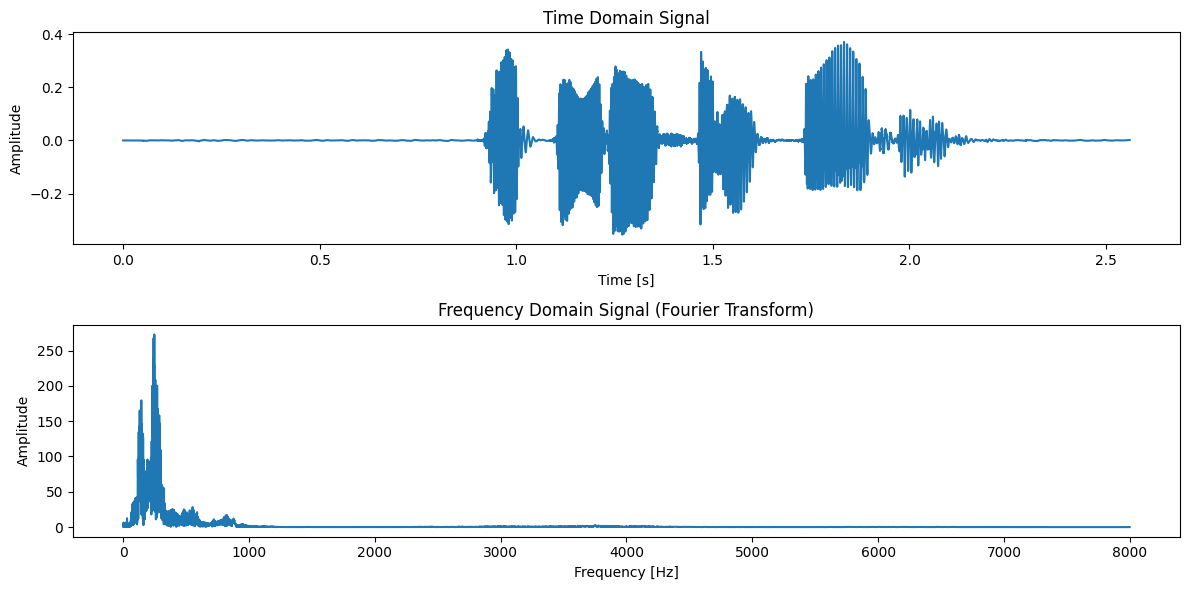

In [5]:
xf = xf[:N//2]
yf = np.abs(yf[:N//2])

# Plot the time domain data
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, audio)
plt.title("Time Domain Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

# Plot the frequency domain data
plt.subplot(2, 1, 2)
plt.plot(xf, yf)
plt.title("Frequency Domain Signal (Fourier Transform)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")

# Show the plots
plt.tight_layout()
plt.show()

# 3. 

**Create dataset of all frenquency domains**

In [6]:
current_task = 1
current_level = 1

data_path = 'dtu_hsc_data/data'
task_level_path = f'Task_{current_task}_Level_{current_level}'
recorded_files_path = 'Recorded'
clean_files_path = 'Clean'

full_path_recorded = os.path.join(data_path, task_level_path, recorded_files_path)
full_path_clean = os.path.join(data_path, task_level_path, clean_files_path)

print(os.listdir(full_path_clean))

['task_1_level_1_clean_469.wav', 'task_1_level_1_clean_005.wav', 'task_1_level_1_clean_090.wav', 'task_1_level_1_clean_575.wav', 'task_1_level_1_clean_520.wav', 'task_1_level_1_clean_437.wav', 'task_1_level_1_clean_554.wav', 'task_1_level_1_clean_139.wav', 'task_1_level_1_clean_332.wav', 'task_1_level_1_clean_496.wav', 'task_1_level_1_clean_395.wav', 'task_1_level_1_clean_013.wav', 'task_1_level_1_clean_249.wav', 'task_1_level_1_clean_475.wav', 'task_1_level_1_clean_555.wav', 'task_1_level_1_clean_056.wav', 'task_1_level_1_clean_546.wav', 'task_1_level_1_clean_016.wav', 'task_1_level_1_clean_025.wav', 'task_1_level_1_clean_045.wav', 'task_1_level_1_clean_531.wav', 'task_1_level_1_clean_209.wav', 'task_1_level_1_clean_141.wav', 'task_1_level_1_clean_192.wav', 'task_1_level_1_clean_101.wav', 'task_1_level_1_clean_170.wav', 'task_1_level_1_clean_250.wav', 'task_1_level_1_clean_593.wav', 'task_1_level_1_clean_501.wav', 'task_1_level_1_clean_328.wav', 'task_1_level_1_clean_311.wav', 'task_1

In [10]:
def sort_by_last_three_digits(files):
    # Define a sorting key function
    def extract_digits(filename):
        # Use regex to find the last three digits before .wav
        match = re.search(r'(\d{3})\.wav$', filename)
        if match:
            return int(match.group(1))  # Return the digits as an integer for sorting
        else:
            return float('inf')  # Return infinity if no match is found, so they go to the end
    
    # Sort the list using the custom key function
    return sorted(files, key=extract_digits)

In [50]:
def load_and_process_data(data_path, get_every=5, min_freq=0, max_freq=1000):
    """_summary_

    Args:
        data_path (_type_): Path to .wav files of data to get
        get_every (int): The granularity of frequencies to get, higher values will get lower number of frequencies 
        min_max_freq (list): Frequencies above or below these values will be cut off

    Returns:
        np.ndarray: Fourier transform of data all collected in one
    """
    glob_path = os.path.join(data_path, '*.wav')
    files_in_dir = glob.glob(glob_path)
    # Sort by last three digits before file extension, so we are sure that the correct clean and recordeds match up with one another
    files_in_dir = sort_by_last_three_digits(files_in_dir)

    data_processed = []

    for file in files_in_dir:
        audio, sr = librosa.load(file, sr=16000, mono=True)

        # Remembr, start:stop:step  
        data_processed.append(np.real(rfft(audio)[min_freq:max_freq:get_every]))
    return np.array(data_processed) 


In [ ]:
def project_to_spline(x_values, y_points):
    """
    Projects x_values onto a linear spline defined by y_points.
    
    Parameters:
    - x_values: a 1D numpy array of x values
    - y_points: a 1D numpy array of y positions corresponding to the control points of the spline.
    
    Returns:
    - projected_y: a 1D numpy array of the same shape as x_values, representing the interpolated y values for each x value.
    """
    
    # Number of points in the y positions
    n_y_points = len(y_points)
    
    # If there are fewer than 2 y_points, we cannot form a spline
    if n_y_points < 2:
        raise ValueError("There must be at least two y points to form a spline.")
    
    # Number of x values
    n_x_values = len(x_values)
    
    # Linearly spaced indices for the y_points (acting as the x-axis for the spline)
    y_indices = np.linspace(0, n_x_values - 1, n_y_points)
    
    # Interpolating the y positions at each x position
    projected_y = np.interp(np.arange(n_x_values), y_indices, y_points)
    
    return projected_y

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

def ridge_regression_spline(x_values, y_points, degree=3, alpha=1.0):
    """
    Fits a ridge regression model to the y_points using a polynomial basis and 
    projects x_values onto the fitted model.

    Parameters:
    - x_values: a 1D numpy array of x values
    - y_points: a 1D numpy array of y positions (control points)
    - degree: degree of the polynomial basis functions (default: 3)
    - alpha: regularization strength for ridge regression (default: 1.0)
    
    Returns:
    - projected_y: a 1D numpy array of the same shape as x_values, representing
      the predicted y values for each x value using the ridge regression model.
    """
    
    # Number of y points and corresponding x-like indices
    n_y_points = len(y_points)
    if n_y_points < 2:
        raise ValueError("There must be at least two y points to fit a model.")
    
    # We use linearly spaced x-values for y_points (acting as the x-axis for fitting)
    y_indices = np.linspace(0, len(x_values) - 1, n_y_points)
    
    # Create polynomial features of the given degree for fitting
    poly = PolynomialFeatures(degree=degree)
    
    # Transform the x-values (design matrix) for fitting the polynomial basis
    X_design = poly.fit_transform(y_indices.reshape(-1, 1))  # y_indices are like x in regression
    
    # Ridge regression model with regularization strength alpha
    ridge = Ridge(alpha=alpha)
    
    # Fit ridge regression model on y_points
    ridge.fit(X_design, y_points)
    
    # Now we project all the x_values (i.e., predict the y_values for all x_values)
    # First, transform the x_values using the same polynomial basis
    X_full = poly.transform(np.arange(len(x_values)).reshape(-1, 1))
    
    # Predict the y values based on the model
    projected_y = ridge.predict(X_full)
    
    return projected_y

# Example usage:
x_vals = np.linspace(0, 10, 50)  # 50 x values
y_pts = np.array([0, 5, 10])     # 3 y points defining the spline

# Ridge regression fit with degree 3 polynomial and regularization alpha=1.0
projected_y = ridge_regression_spline(recorded_data, clean_data, degree=3, alpha=1.0)
print(projected_y)


In [53]:
from sklearn.linear_model import Ridge
from scipy.interpolate import interp1d
import numpy as np

def ridge_regression_fourier_with_interpolation(X_noisy, Y_clean, alpha=1.0):
    """
    Fits ridge regression models for each row of Fourier coefficients from noisy signals to clean signals,
    then interpolates the fitted clean coefficients to match the granularity of the noisy data.
    
    Parameters:
    - X_noisy: 2D numpy array of shape (600, 200) containing Fourier coefficients of noisy signals
    - Y_clean: 2D numpy array of shape (600, n_features) containing Fourier coefficients of clean signals
               with fewer features than X_noisy
    - alpha: Regularization strength for ridge regression (default: 1.0)
    
    Returns:
    - Y_pred: 2D numpy array of interpolated clean Fourier coefficients of shape (600, 200)
    """
    # Ensure the number of rows matches between X_noisy and Y_clean
    assert X_noisy.shape[0] == Y_clean.shape[0], "Shape mismatch between X_noisy and Y_clean along axis 0"

    n_noisy_features = X_noisy.shape[1]  # Number of features in the noisy signal
    n_clean_features = Y_clean.shape[1]  # Number of features in the clean signal (less granular)

    # Preallocate for predicted clean Fourier coefficients (complex-valued array)
    Y_pred = np.zeros_like(X_noisy, dtype=complex)  # We'll interpolate into the shape of X_noisy

    # Perform ridge regression and interpolation for each row of Fourier coefficients
    for i in range(X_noisy.shape[0]):
        # Extract real and imaginary parts of the noisy and clean Fourier coefficients for the i-th row
        X_real = X_noisy[i].real
        X_imag = X_noisy[i].imag
        Y_real = Y_clean[i].real
        Y_imag = Y_clean[i].imag
        
        # Generate indices for the clean (lower resolution) Fourier coefficients
        clean_indices = np.linspace(0, n_noisy_features - 1, n_clean_features)
        
        # Ridge regression for real part
        ridge_real = Ridge(alpha=alpha)
        ridge_real.fit(clean_indices.reshape(-1, 1), Y_real)
        Y_pred_real_clean = ridge_real.predict(clean_indices.reshape(-1, 1))
        
        # Ridge regression for imaginary part
        ridge_imag = Ridge(alpha=alpha)
        ridge_imag.fit(clean_indices.reshape(-1, 1), Y_imag)
        Y_pred_imag_clean = ridge_imag.predict(clean_indices.reshape(-1, 1))
        
        # Combine predicted real and imaginary parts into complex Fourier coefficients (at lower resolution)
        Y_pred_clean = Y_pred_real_clean + 1j * Y_pred_imag_clean

        # Now interpolate the predicted coefficients to match the granularity of the noisy signal
        # Create interpolating functions for real and imaginary parts
        interp_real = interp1d(clean_indices, Y_pred_real_clean, kind='linear', fill_value="extrapolate")
        interp_imag = interp1d(clean_indices, Y_pred_imag_clean, kind='linear', fill_value="extrapolate")

        # Interpolate to the granularity of the noisy coefficients
        noisy_indices = np.arange(n_noisy_features)
        Y_pred_real_full = interp_real(noisy_indices)
        Y_pred_imag_full = interp_imag(noisy_indices)
        
        # Combine real and imaginary parts into the final predicted Fourier coefficients
        Y_pred[i] = Y_pred_real_full + 1j * Y_pred_imag_full

    return Y_pred

# # Example usage:
# # X_noisy: 600x200 array of Fourier coefficients for noisy signals (higher granularity)
# # Y_clean: 600x50 array of Fourier coefficients for clean signals (lower granularity)
# X_noisy = np.random.randn(600, 200) + 1j * np.random.randn(600, 200)  # Example complex data
# Y_clean = np.random.randn(600, 50) + 1j * np.random.randn(600, 50)  # Lower granularity clean signal data

# Fit ridge regression with regularization strength alpha=1.0, followed by interpolation
Y_pred = ridge_regression_fourier_with_interpolation(recorded_data, clean_data, alpha=1.0)
print(Y_pred.shape)  # Should output (600, 200), matching the shape of X_noisy


AttributeError: 'interp1d' object has no attribute 'shape'

In [51]:
# Create recorded and clean datasets
recorded_data = load_and_process_data(full_path_recorded)
clean_data = load_and_process_data(full_path_clean)

print(recorded_data.shape)
    

(600, 200)


In [49]:
from sklearn import linear_model

clf = linear_model.Ridge(alpha=0.1, fit_intercept=False)

clf.fit(recorded_data, clean_data)

# print(clf.coef_)
# print(clf.intercept_)

print(clf.coef_.shape)

clf.coef


(100, 100)


In [61]:
from scipy.interpolate import RegularGridInterpolator
import numpy as np

x_grid = np.linspace(0, 100, 100)
y_grid = np.linspace(0, 100, 100)

interp = RegularGridInterpolator((x_grid, y_grid), clf.coef_)

In [55]:
from scipy.interpolate import RegularGridInterpolator

import numpy as np

def f(x, y, z):

    return 2 * x**3 + 3 * y**2 - z

x = np.linspace(1, 4, 11)

y = np.linspace(4, 7, 22)

z = np.linspace(7, 9, 33)

xg, yg ,zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

data = f(xg, yg, zg)

interp = RegularGridInterpolator((x, y, z), data)

In [60]:
print(xg.shape)
print(yg.shape)
print(y.shape)

print(data.shape)

(11, 1, 1)
(1, 22, 1)
(22,)
(11, 22, 33)
